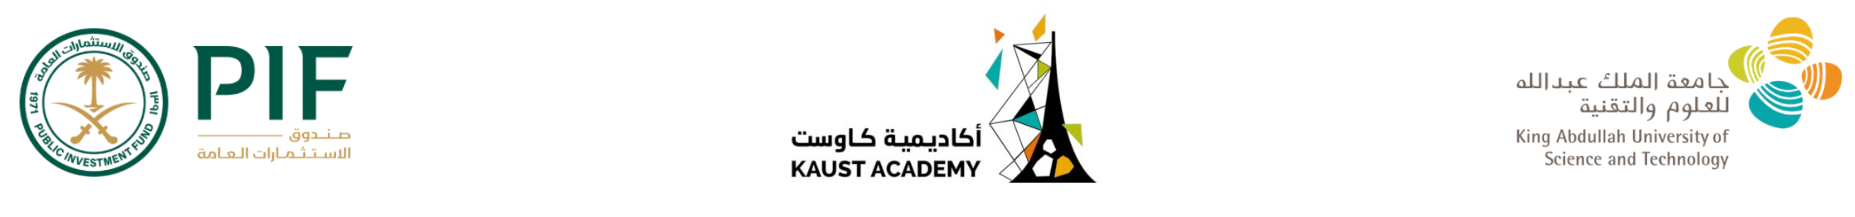

In [25]:
#@title Reqs (please ignore it)
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=10, device="cpu"):
    model.to(device)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):

        # -------- Train --------
        model.train()
        running_loss = 0.0

        for X, y in train_loader:
            X = X.view(X.size(0), -1).to(device)  # flatten
            y = y.to(device)

            outputs = model(X)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * y.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # -------- Validate --------
        model.eval()
        running_val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.view(X_val.size(0), -1).to(device)
                y_val = y_val.to(device)

                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                running_val_loss += loss.item() * y_val.size(0)

                preds = outputs.argmax(dim=1)
                correct += (preds == y_val).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        accuracy = correct / len(val_loader.dataset)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {epoch_train_loss:.4f} "
              f"Val Loss: {epoch_val_loss:.4f} "
              f"Val Acc: {accuracy*100:.2f}%")

    print(f"Training complete on device {device}")
    return train_losses, val_losses, val_accuracies

def evaluate_model(model, data_loader, criterion, device="cpu"):
    model.eval()
    model.to(device)

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in data_loader:
            X = X.view(X.size(0), -1).to(device)   # flatten for FC network
            y = y.to(device)

            outputs = model(X)
            loss = criterion(outputs, y)

            running_loss += loss.item() * y.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total

    print(f"val_loss={avg_loss:.4f}. "
          f"labelled {correct}/{total} correctly "
          f"({accuracy*100:.2f}% accuracy)")

    return avg_loss, accuracy

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_reg_model(model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=10, device="cpu"):

    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):

        # -------- TRAIN --------
        model.train()
        running_train_loss = 0.0

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            preds = model(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * y.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # -------- VALIDATION --------
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)

                preds = model(X_val)
                loss = criterion(preds, y_val)

                running_val_loss += loss.item() * y_val.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {epoch_train_loss:.4f} "
              f"Val Loss: {epoch_val_loss:.4f}")

    print(f"Training complete on device {device}")
    return train_losses, val_losses


Using device: cuda


In [ ]:
from IPython.display import clear_output

In [ ]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install matplotlib
%pip install torchvision

clear_output()

In [ ]:
import torch

import torch.nn as nn

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.transforms.functional import to_tensor

import matplotlib.pyplot as plt

In [ ]:
# CIFAR10 function fetches the CIFAR10 dataset. Without any transform param, the returned object is a Pillow image but we want to convert it to numerical form
# that is to say, a numpy array/torch tensor


# Download & load CIFAR-10
# to_tensor is used to avoid errors when creating data loader later. we'll convert them to numpy arrays when the time comes

train_data = CIFAR10(root='./data', train=True, download=True, transform=to_tensor)
test_data = CIFAR10(root='./data', train=False, download=True, transform=to_tensor)

clear_output()

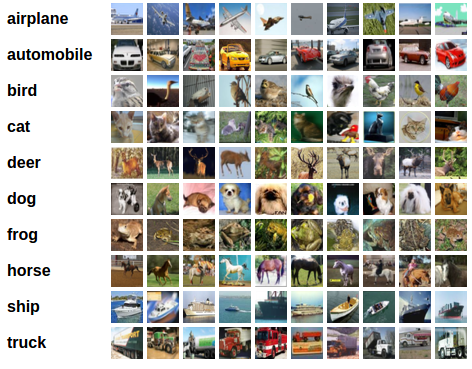

In [ ]:
classes = train_data.classes
print("Classes:", classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
batch_size = 64

# Dataloaders are used to easily create batches of data so we can perform batch gradient descent for faster learning
train_loader = DataLoader(train_data, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

## Models

let's create the architecture of our models

Instead of sigmoid activation, we'll use softmax activation

The difference is:
- sigmoid brings each value in the range 0-1
- softmax takes a vector and changes the value into probabilities: i.e the sum of those values = 1. The highest value in the original vector retains the highest value in softmax output

Here's the formula for softmax:

$$
\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$

In [ ]:
class NN1Layer(nn.Module):

    def __init__(self, num_inp, num_out):

        super(NN1Layer, self).__init__()

        self.layer_1 = nn.Linear(num_inp, num_out)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):

        z = self.layer_1(x)
        a = self.softmax(z) # if you softmax -> use NLLLoss
        # a = z # No softmax use CrossEntropy
        return a


class NN2Layer(nn.Module):

    def __init__(self, num_inp, num_hidden, num_out):

        super(NN2Layer, self).__init__()

        self.layer_1 = nn.Linear(num_inp, num_hidden)
        self.layer_2 = nn.Linear(num_hidden, num_out)

        self.hidden_activation = nn.ReLU()  # We can change the hidden activation (activation in between layer 1 and 2) here
        self.softmax = nn.Softmax(dim=1)  # dim 0 is normally batch size, we don't want to apply softmax across batch size

    def forward(self, x):

        z1 = self.layer_1(x)
        a1 = self.hidden_activation(z1)

        z2 = self.layer_2(a1)
        a2 = self.softmax(z2)

        return a2

## The main training loop, with batch gradient descent.



Declare model, it's params, optimizers and criterion etc

We'll also declare a device here. This will let us use GPU
you can see how much difference a GPU makes by changing the device param to cpu and cuda

In [ ]:
num_epochs = 12
lr = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu

train_losses = []
val_losses = []


model = NN1Layer(32*32*3, 10)

optimizer = Adam(model.parameters(), lr=lr)
# criterion = nn.CrossEntropyLoss()  # multi-class without softmaxing at the end
criterion = nn.NLLLoss()             # with log softmax

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')

Using device cuda


Pre-train performance

In [ ]:
%%time
model.eval()
correctly_labelled = 0

with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in test_loader:

        val_batch_X = val_batch_X.view(-1, 32*32*3).to(device)
        val_batch_y = val_batch_y.to(device)

        val_batch_y_probs = model(val_batch_X)

        loss = criterion(val_batch_y_probs, val_batch_y)
        val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

        correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
val_losses.append(val_epoch_loss)

print(f'val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

val_loss=2.3231051040649415. labelled 1374/10000 correctly (13.74% accuracy)
CPU times: user 1.47 s, sys: 2.59 ms, total: 1.48 s
Wall time: 1.5 s


Training the model

In [ ]:
%%time
for epoch_no in range(num_epochs):

    model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

    epoch_weighted_loss = 0

    for batch_X, batch_y in train_loader:

        batch_X = batch_X.view(-1, 32*32*3).to(device)  # convert to [N, 28*28] shape where N is batch_size
        batch_y = batch_y.to(device)

        batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

        loss = criterion(batch_y_probs, batch_y)

        optimizer.zero_grad()  # need to clear out gradients from previous batch
        loss.backward()  # calculate new gradients
        optimizer.step()  # update weights

        epoch_weighted_loss += (len(batch_y)*loss.item())

    epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
    train_losses.append(epoch_loss)    # add loss for tracking. we'll visualize the loss trajectory later


    # validation time

    model.eval()  # take model to evaluation mode. turn off train-only layers
    correctly_labelled = 0

    with torch.no_grad():  # this makes our model to NOT track gradients

        val_epoch_weighted_loss = 0

        for val_batch_X, val_batch_y in test_loader:

            val_batch_X = val_batch_X.view(-1, 32*32*3).to(device)
            val_batch_y = val_batch_y.to(device)

            val_batch_y_probs = model(val_batch_X)

            loss = criterion(val_batch_y_probs, val_batch_y)
            val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

            val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

            correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

    val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
    val_losses.append(val_epoch_loss)

    print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')

Epoch: 0, train_loss=1.9880676427459716, val_loss=1.8959206972122193. labelled 3493/10000 correctly (34.93% accuracy)
Epoch: 1, train_loss=1.859684453163147, val_loss=1.8335228607177734. labelled 3679/10000 correctly (36.79% accuracy)
Epoch: 2, train_loss=1.822123353729248, val_loss=1.8233265295028687. labelled 3626/10000 correctly (36.26% accuracy)
Epoch: 3, train_loss=1.802665739250183, val_loss=1.811259485244751. labelled 3662/10000 correctly (36.620000000000005% accuracy)
Epoch: 4, train_loss=1.7876641157531739, val_loss=1.7863548467636108. labelled 3820/10000 correctly (38.2% accuracy)
Epoch: 5, train_loss=1.7751624564743043, val_loss=1.7769449905395507. labelled 3857/10000 correctly (38.57% accuracy)
Epoch: 6, train_loss=1.7678181114196778, val_loss=1.7735485509872437. labelled 3896/10000 correctly (38.96% accuracy)
Epoch: 7, train_loss=1.760768955154419, val_loss=1.7724836978912353. labelled 3919/10000 correctly (39.190000000000005% accuracy)
Epoch: 8, train_loss=1.7543547553253

Loss trajectory

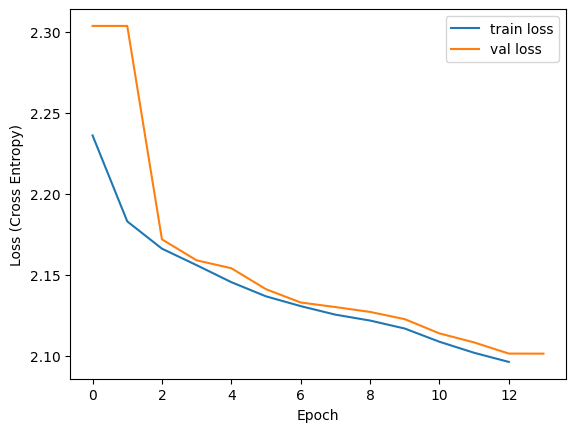

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

## Task 1 train a classification neural network on FashionMNIST

- (Task 1) Define a Neural Network class
- (Task 2) Make it inherit nn.Module class
- (Task 3) Define the layers inside the constructor using nn.Sequential
- (Task 4) Define the forward
- (Task 5) move the model to the device (model agnostic)
- (Task 6) write the hyperparms
- (Task 7) Run the code and plot

In [5]:
#@title fashion mnist information
class_names = train_dataset.classes
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("Class names:", class_names)
print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Number of classes: 10
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Training samples: 60000
Test samples: 10000


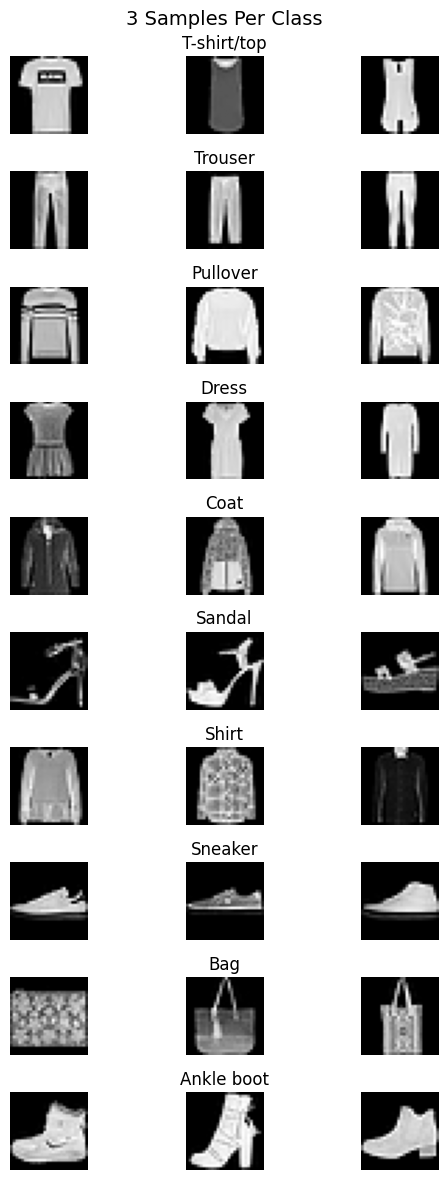

In [4]:
#@title samples per class
fig, axes = plt.subplots(num_classes, 3, figsize=(6, 12))
fig.suptitle("3 Samples Per Class", fontsize=14)

# Track how many images collected per class
collected = {c: 0 for c in range(num_classes)}

for img, label in train_dataset:
    if collected[label] < 3:
        ax = axes[label, collected[label]]
        ax.imshow(img.squeeze(), cmap="gray")
        ax.axis("off")
        if collected[label] == 1:   # print label once per row
            ax.set_title(class_names[label])
        collected[label] += 1

    if all(v == 3 for v in collected.values()):
        break

plt.tight_layout()
plt.show()


In [ ]:
import torch.nn.functional as F
#TODO create the NN class from scratch
class

    #TODO Define the constructor
    def
        #TODO write the super function
        super().

        #TODO write some layers using nn.Sequential
        layers =

    #TODO define the forward function
    def

#define an instance of the neural net
model1 =
model.to(device)

In [11]:
import torch.nn.functional as F

#TODO create the NN class from scratch
class NN1Layer(nn.Module):

    #TODO Define the constructor
    def __init__(self):

        #TODO write the super function
        super().__init__()

        #TODO write some layers using nn.Sequential
        self.layers = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)   # 10 outputs
        )

    #TODO define the forward function
    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten
        out = self.layers(x)
        return out


model1 = NN1Layer()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Training on:", device)

model1.to(device)

Training on: cuda


NN1Layer(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
#@title hyperparams

num_epochs1 = 5     # write any number, number of epochs is how many
                    # iterations you want to train your neural net
                    # a good range usually from 20 - 50 epochs

learning_rate = 1e-3    # a good range is from (0.01 - 0.0001)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)
# you can choose SGD, Adam, or AdamW
# torch.optim.SGD(model1.parameters(), lr=learning_rate, momentum=0.9)
# torch.optim.Adam(model1.parameters(), lr=learning_rate)
# torch.optim.AdamW(model1.parameters(), lr=learning_rate)

criterion1 = nn.CrossEntropyLoss()
                    # you should choose depending of you have
                    # choose nn.NLLLoss() if you have used LogSoftmax at the end of the NN
                    # choose nn.CrossEntropy() if you haven't used last activation

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
#@title run train
%%time
train_losses1, val_losses1, val_acc1 = train_model(
    model=model1,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion1,
    optimizer=optimizer1,
    num_epochs=num_epochs1,
    device=device
)

Epoch 1/5 Train Loss: 0.4932 Val Loss: 0.4768 Val Acc: 83.19%
Epoch 2/5 Train Loss: 0.3689 Val Loss: 0.3942 Val Acc: 85.25%
Epoch 3/5 Train Loss: 0.3326 Val Loss: 0.3788 Val Acc: 86.00%
Epoch 4/5 Train Loss: 0.3040 Val Loss: 0.3503 Val Acc: 87.17%
Epoch 5/5 Train Loss: 0.2849 Val Loss: 0.3368 Val Acc: 87.87%
Training complete on device cuda
CPU times: user 1min 17s, sys: 272 ms, total: 1min 17s
Wall time: 1min 18s


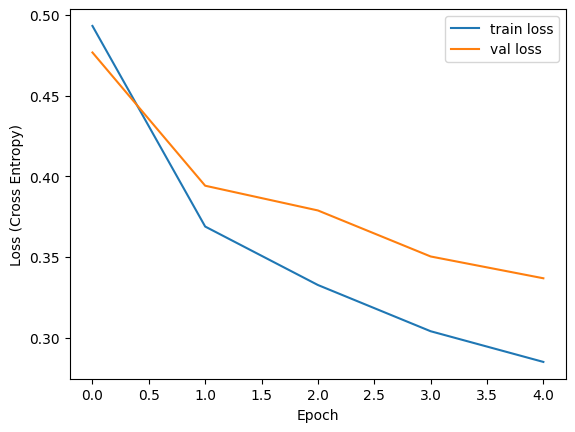

Final Accuracy: 87.87


In [19]:
#@title run plotting the learning curve
plt.plot(train_losses1, label='train loss')
plt.plot(val_losses1, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()
print(f'Final Accuracy: {val_acc1[-1]*100:.2f}')

## Task 2 train a regression neural network on California house prices
- (Task 1) Write the layers of this regression neural network
- (Task 2) Choose the appropriate loss function
- (Task 3) Run and plot

In [26]:
#@title Data information (Ignore the code)
# Load datasets
train_df = pd.read_csv("/content/sample_data/california_housing_train.csv")
test_df  = pd.read_csv("/content/sample_data/california_housing_test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

target_column = "median_house_value"

X_train = train_df.drop(columns=[target_column]).values
y_train = train_df[target_column].values

X_test  = test_df.drop(columns=[target_column]).values
y_test  = test_df[target_column].values

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

train_loader2 = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader2  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train batches:", len(train_loader2))
print("Test batches:", len(test_loader2))

train_df.head(), test_df.head()

Train shape: (17000, 9)
Test shape: (3000, 9)
Train batches: 266
Test batches: 47


(   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 0    -114.31     34.19                15.0       5612.0          1283.0   
 1    -114.47     34.40                19.0       7650.0          1901.0   
 2    -114.56     33.69                17.0        720.0           174.0   
 3    -114.57     33.64                14.0       1501.0           337.0   
 4    -114.57     33.57                20.0       1454.0           326.0   
 
    population  households  median_income  median_house_value  
 0      1015.0       472.0         1.4936             66900.0  
 1      1129.0       463.0         1.8200             80100.0  
 2       333.0       117.0         1.6509             85700.0  
 3       515.0       226.0         3.1917             73400.0  
 4       624.0       262.0         1.9250             65500.0  ,
    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 0    -122.05     37.37                27.0       3885.0           661.0   
 1   

In [ ]:
class Regression_NN(nn.Module):
    def __init__(self, ):
        super().__init__()

        layers = nn.Sequential(
        # TODO write the layers here, add or remove as you like
            ,
            ,
            ,
        )


    def forward(self, input):

        return pass

In [23]:
class Regression_NN(nn.Module):
    def __init__(self):
        super().__init__()

        input_dim = X_train.shape[1]   # number of features

        self.layers = nn.Sequential(
            # TODO write the layers here, add or remove as you like
            nn.Linear(input_dim, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)   # regression output
        )

    def forward(self, input):
        output = self.layers(input)
        return output


model2 = Regression_NN()
model2.to(device)

Regression_NN(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [29]:
#@title hyperparams

#predefined
num_epochs2 = 100
learning_rate = 1e-3
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

#TODO choose the correct loss function
# OPTION 1 (RECOMMENDED):
criterion2 = nn.MSELoss()

# OPTION 2:
# criterion2 = nn.L1Loss()

# OPTION 3:
# criterion2 = nn.SmoothL1Loss()

# DO NOT USE THESE FOR REGRESSION
# nn.NLLLoss()      -> classification only
# nn.CrossEntropyLoss() -> classification only

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
#@title run train
train_losses2, val_losses2 = train_reg_model(
    model=model2,
    train_loader=train_loader2,
    val_loader=test_loader2,
    criterion=criterion2,
    optimizer=optimizer2,
    num_epochs=num_epochs2,
    device=device
)

Epoch 1/100 Train Loss: 11574048570.9101 Val Loss: 10841046032.3840
Epoch 2/100 Train Loss: 11020653216.7078 Val Loss: 10629198465.7067
Epoch 3/100 Train Loss: 10813151079.2433 Val Loss: 10466403341.6533
Epoch 4/100 Train Loss: 10661745757.4852 Val Loss: 10308199516.8427
Epoch 5/100 Train Loss: 10491328986.6541 Val Loss: 10175567653.5467
Epoch 6/100 Train Loss: 10325418885.6019 Val Loss: 10103745890.9867
Epoch 7/100 Train Loss: 10182629888.7228 Val Loss: 9910643362.4747
Epoch 8/100 Train Loss: 10017802886.6861 Val Loss: 9684868456.4480
Epoch 9/100 Train Loss: 9858692854.0009 Val Loss: 9529455536.8107
Epoch 10/100 Train Loss: 9691629027.8099 Val Loss: 9430759806.2933
Epoch 11/100 Train Loss: 9500123947.0080 Val Loss: 9239912663.7227
Epoch 12/100 Train Loss: 9358593463.7176 Val Loss: 9104134365.1840
Epoch 13/100 Train Loss: 9160160040.1167 Val Loss: 8852123219.2853
Epoch 14/100 Train Loss: 8946998016.6024 Val Loss: 8632262688.7680
Epoch 15/100 Train Loss: 8736671026.9591 Val Loss: 844541

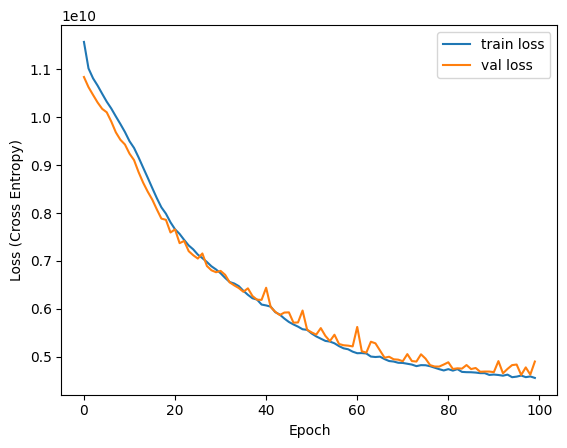

Final Score: 0.8787


In [31]:
#@title run plotting the learning curve
plt.plot(train_losses2, label='train loss')
plt.plot(val_losses2, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()
print(f'Final Score: {val_acc1[-1]}')